# Preprocessing

## Import Libraries

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import scipy.ndimage
import matplotlib.pyplot as plt
import pydicom
import os
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import sys
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk
import pylidc as pl
from pylidc.utils import consensus
from pylidc.utils import volume_viewer

## Data Preprocessing

### Exploring the LIDC-IDRI dataset

Load the metadata.csv and see what information can we get from it.

In [2]:
metadata = pd.read_csv('metadata.csv')
metadata.head(1)

Series UID Collection  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...  LIDC-IDRI   

   3rd Party Analysis                           Data Description URI  \
0                 NaN  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   

       Subject ID                                          Study UID  \
0  LIDC-IDRI-0002  1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...   

  Study Description  Study Date Series Description        Manufacturer  \
0               NaN  01-01-2000                NaN  GE MEDICAL SYSTEMS   

  Modality                                  SOP Class Name  \
0       DX  Digital X-Ray Image Storage - For Presentation   

                 SOP Class UID  Number of Images File Size  \
0  1.2.840.10008.5.1.4.1.1.1.1                 1   6.91 MB   

                                       File Location       Download Timestamp  
0  ./LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-26...  2023-10-05T12:40:37.146

In [3]:
metadata.columns

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')

------------------------

Next, we start exploring the CT scans with the pydicom library.
First we get the file location corresponding to the subject from some row of the metadata.
Some folders have multiple dicom files which together form the whole CT image. We open a few of those .dcm files:

In [4]:
dir = metadata.loc[2]['File Location']
dir

'./LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192'

In [5]:
CT_folder = os.path.join(dir)
ct1 = pydicom.read_file(os.path.join(CT_folder, '1-001.dcm'))
ct2 = pydicom.read_file(os.path.join(CT_folder, '1-132.dcm'))
image1 = ct1.pixel_array
image2 = ct2.pixel_array

The images are 2D arrays. Typically the pixel values are stored in a scaled format so we should adjust them back to Houndsfield units:

In [6]:
image1 = ct1.RescaleSlope * image1 + ct1.RescaleIntercept
image2 = ct2.RescaleSlope * image2 + ct2.RescaleIntercept

In [7]:
plt.pcolormesh(image1, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

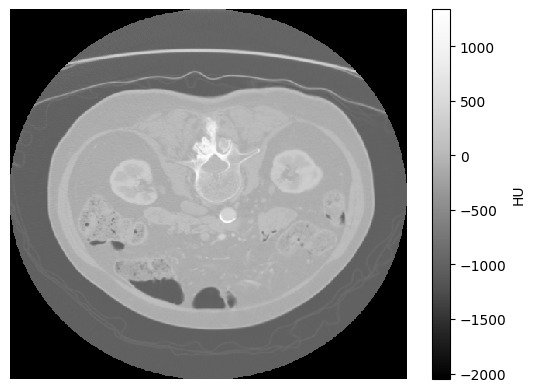

In [8]:
plt.pcolormesh(image2, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

### Exploring pylidc library

We begin exploring with the pylidc library, which is made for working with LIDC dataset. This library will be the basis of our work.

First we load all scans from the pylidc.Scan class, which holds some of the DICOM attributes associated with the CT scans in the LIDC dataset. And also all the annotations from the XML files. 

In [9]:
scans = pl.query(pl.Scan).all()

In [10]:
annotations = pl.query(pl.Annotation).all()

We are going to take the a random scan try to visualize it using pylidc methods.

In [11]:
scan = scans[4]
print(scan.patient_id)

LIDC-IDRI-0110


Each scan has multiple annotations refering to different nodules. We use the cluster_annotations() method to estimate which annotations refer to the same nodule in the CT scan.

In [12]:
nods = scan.cluster_annotations()

Now we can visualize the scan along with important informations about the nodules:

Loading dicom files ... This may take a moment.


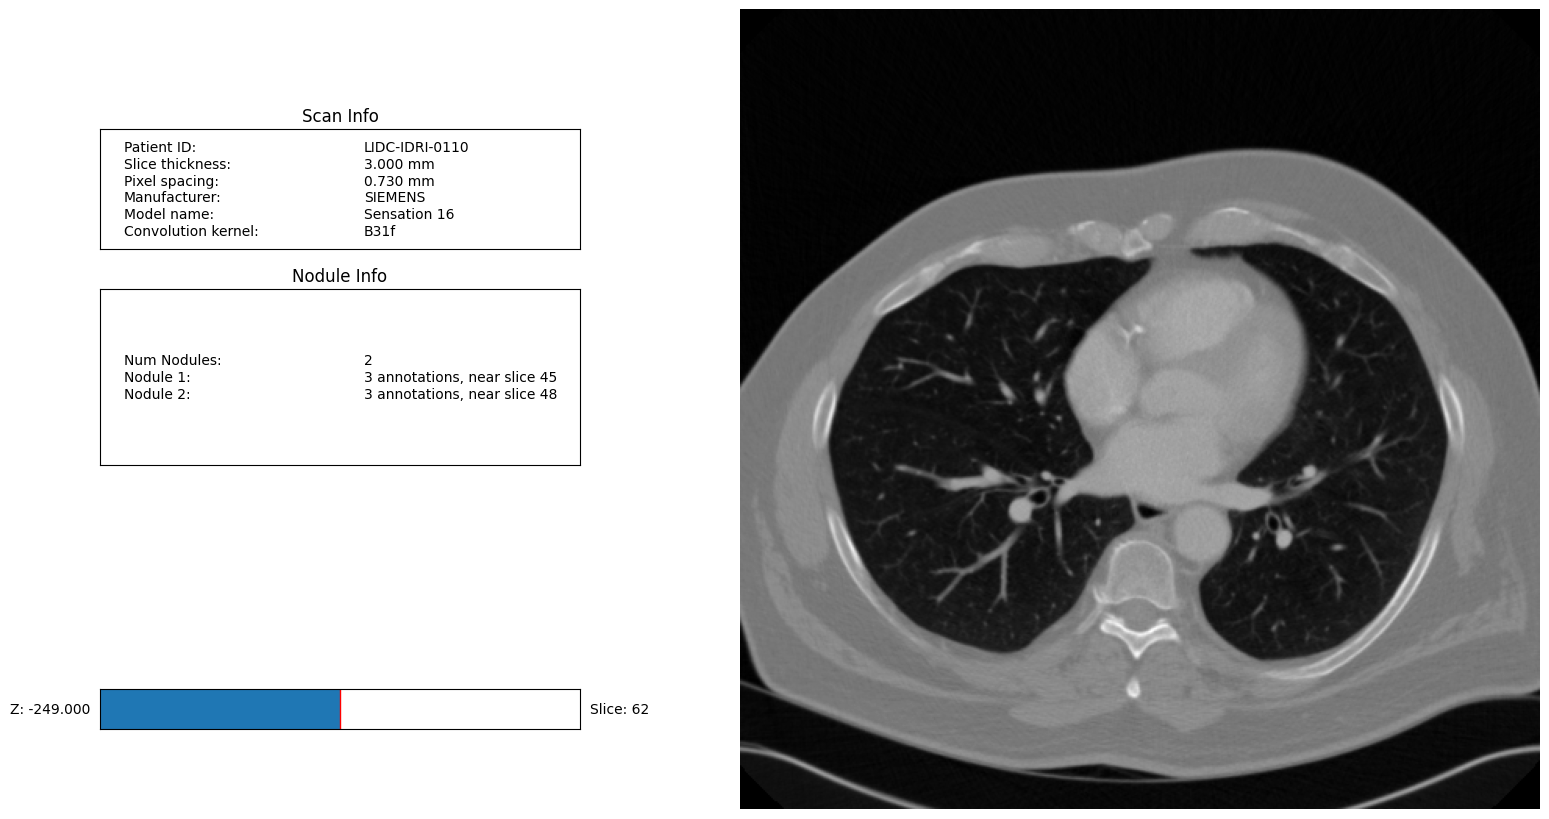

In [13]:
scan.visualize(annotation_groups=nods)

The annotation class also has some methods visualize the scan with respect to the nodules. In this case we take two annotations from the same patient and analyse that they refer to two different nodules:

In [14]:
ann1 = annotations[0]
ann2 = annotations[1]

In [15]:
ann1.visualize_in_scan()

Loading dicom files ... This may take a moment.


Loading dicom files ... This may take a moment.


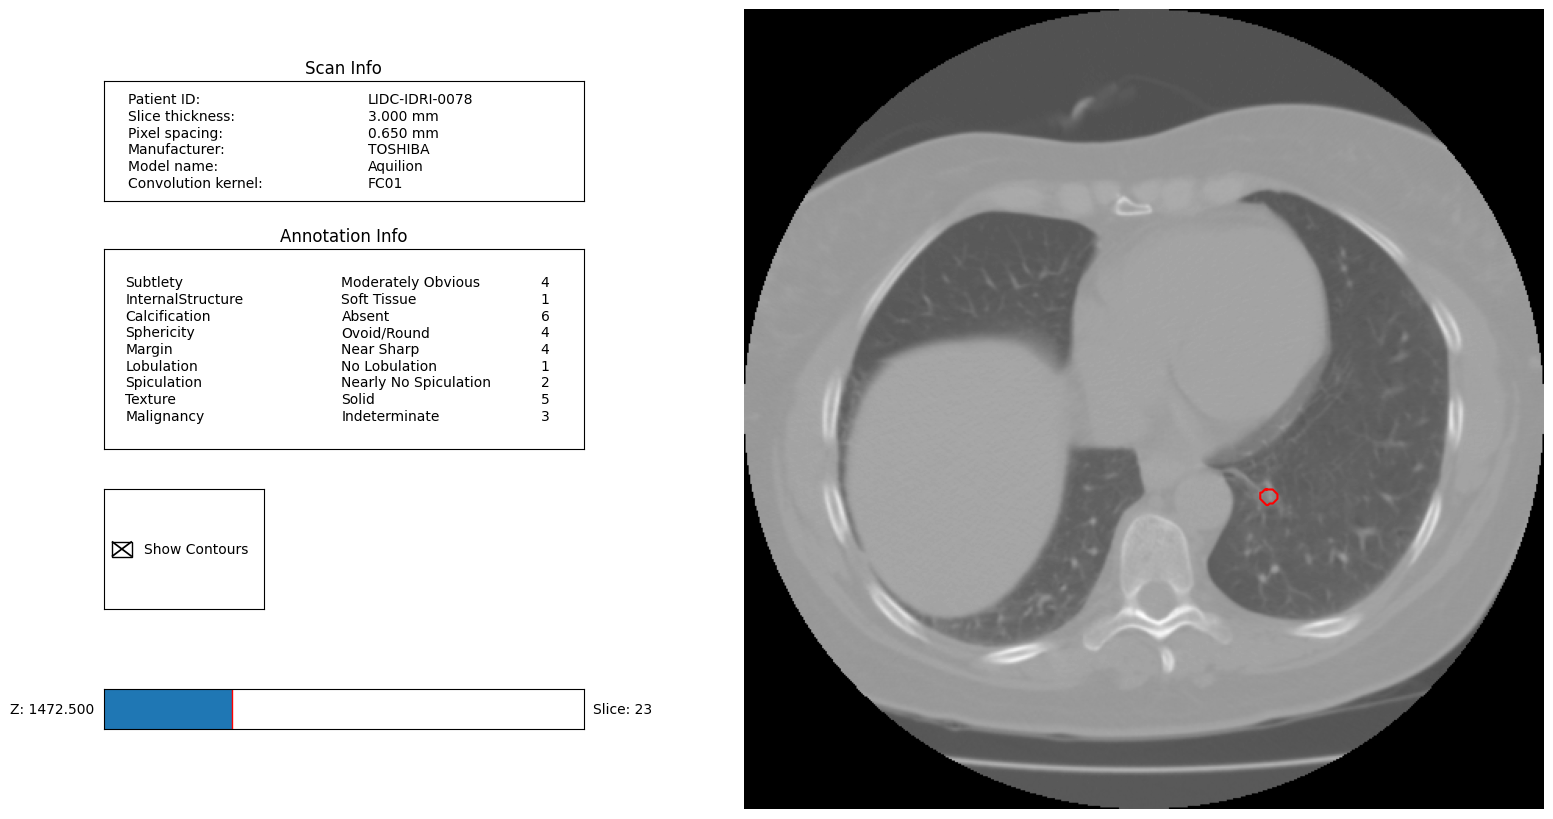

In [16]:
ann2.visualize_in_scan()

Next, we use visualize both nodules in 3d:

In [17]:
ann1.visualize_in_3d()

/home/claudia/anaconda3/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/home/claudia/Projeto1/lib/python3.9/site-packages/pylidc/Annotation.py:764: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  facecolors=plt.cm.cmap_d[cmap](t))


In [18]:
ann2.visualize_in_3d()

After exploring our data, seeing how to get images from the CT scan slices and how to get information about the various nodules, we need start thinking about feature extraction. For that purpose, we can take some features directly out of pylidc but we also want to extract features with the pyradiomics library.

### Creating a Mask

To extract features from pyradiomics, we need to create a mask.

In [20]:
# Return the scan as a 3D numpy array volume.
ann = annotations[0]
vol = ann.scan.to_volume()

Loading dicom files ... This may take a moment.


In [21]:
padding = 70.0
bbox = ann.bbox(pad=padding)
volume_viewer(vol[bbox])

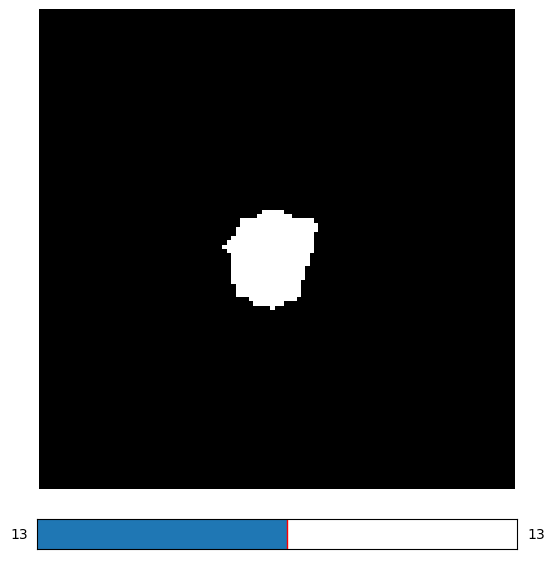

In [22]:
mask = ann.boolean_mask(pad = padding)
volume_viewer(mask)

### Extracting the Features and Creating the Dataframe

Now we can start extracting some features and inserting them in a dataframe.

To do that, we created some functions:

In [23]:
def ann_row(ann):
    ids = np.array([ann.scan.patient_id, ann.id, ann.scan_id], dtype = '<U14')
    others = np.array([ann.diameter,ann.surface_area, ann.volume])
    features = ann.feature_vals()
    return(ids, others, features)    

In [24]:
def anns_df(anotacoes):
    # Make sure that we are working with a list
    if  not isinstance(anotacoes, list):
        anotacoes = [anotacoes]
    
    # Create 3 dataframes:
    df_id = pd.DataFrame(columns = ["Patient_id", "Annotation_id", "Scan_id"])
    df_others =pd.DataFrame(columns = ["Diameter", "SurfaceArea", "Volume"])
    df_feat = pd.DataFrame(columns=['Subtlety', 'Internalstructure', 'Calcification','Sphericity','Margin','Lobulation',
                           'Spiculation','Texture','Malignancy'])
    
    #JOin the 3 dataframes in one single dataframe:
    for i, ann in enumerate(anotacoes):
        array_id,array_other, array_feat = ann_row(ann)
        df_id.loc[i] = array_id
        df_others.loc[i] = array_other
        df_feat.loc[i] = array_feat
    
    df = pd.concat([df_id, df_others], axis = 1)
    df1 = pd.concat([df, df_feat], axis = 1)
    return(df1)  

In [25]:
def id_nodulo(scans):
    nodulos = pd.DataFrame(columns = ['Nodule_Id', 'Patient_id', 'Annotation_id', 'Scan_id'])
    i = 1
    j = 0
    for scan in scans:
        patient = scan.patient_id
        nods = scan.cluster_annotations()
        for anns in nods:
            for ann in anns:
                lista = []
                lista.append(i)
                lista.append(patient)
                lista.append(ann.id)
                lista.append(ann.scan_id)
                nodulos.loc[j] = lista
                j = j+1
            i = i+1
    return(nodulos)

In [26]:
def juntar(df1, df2):
    #df1 = annotations 
    #df2 = nodules
    df = df1.merge(df2[['Patient_id', 'Annotation_id', 'Scan_id', 'Nodule_Id']], 
                    on=['Patient_id', 'Annotation_id', 'Scan_id'], how='left')
    ordem_colunas = [df.columns[0], 'Nodule_Id'] + list(df.columns[1:-1]) #Reorder the columns
    df = df[ordem_colunas]
    return(df)

In [27]:
def cluster(df):
    # Remove some id columns and group all annotations based on their respetive nodules
    df1 = df.drop(['Patient_id', 'Annotation_id'], axis=1)
    group = df1.groupby('Nodule_Id').mean().reset_index()

    #Add the 'Patient_id' column
    df2 = df[['Patient_id', 'Nodule_Id']] 
    df2 = df2.sort_values(by='Nodule_Id', ascending=True, ignore_index=True) # Ordering Nodule_id by ascending order
    df2 = df2.drop_duplicates(subset='Nodule_Id')  # Getting only one row for each nodule
    df2 = df2.reset_index(drop=True) # Redefine the dataframe columns

    group['Patient_id'] = df2['Patient_id'] 
    ordem_colunas = ['Patient_id'] + list(group.columns[0:-1]) #Reorder the columns
    group = group[ordem_colunas]
    group['Scan_id'] = group['Scan_id'].astype(int) # float to int

    return(group)



These functions were made to create a dataframe with the features that we can extract directly from the pylidc library. 


- First, we create the function 'ann_row' which takes an annotation and gathers a bunch of attributes useful for classification.

- Next, we use the the 'anns_df' function to go through all the annotations, extract the features of each one with the preavious function and create a dataframe with the results.

- Then we create the 'id_nodulo' function that takes all the scans, uses the cluster_annotations method for each scan to identify every single nodule in the dataset (based on the annotations).

- After that, we need to use 'juntar' to join the two dataframes created with 'anns_df' and 'id_nodule'. That way, every annotation is associated with a nodule.

We get this dataframe as a result:

In [28]:
df =  pd.read_csv('pylidc_nod.csv')
df.head(5)

Patient_id  Nodule_Id  Annotation_id  Scan_id   Diameter  SurfaceArea  \
0  LIDC-IDRI-0078          2              1        1  20.840585  1124.125177   
1  LIDC-IDRI-0078          1              2        1  19.500000  1135.239277   
2  LIDC-IDRI-0078          4              3        1  23.300483  1650.898027   
3  LIDC-IDRI-0078          4              4        1  32.810517  1994.684094   
4  LIDC-IDRI-0078          2              5        1  20.891206  1130.172711   

       Volume  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0  2439.30375         5                  1              6           3       4   
1  2621.82375         4                  1              6           4       4   
2  4332.31500         5                  1              4           3       5   
3  5230.33875         5                  1              6           4       2   
4  2443.74000         4                  1              6           4       2   

   Lobulation  Spiculation  Texture  Malignancy  
0           1            1        5           3  
1           1            2        5           3  
2           2            3        5           4  
3           4            1        5           5  
4           3            1        4           4

- The last function 'cluster' takes the dataframe created with the previous functions and groups all the annotations by nodule_id. To do that, we need to remove the 'Annotation_id' column and calculate the mean of all annotations that refer to the same nodule.

In [29]:
df1 =  pd.read_csv('pylidc_grouped.csv')
df1.head()

Patient_id  Nodule_Id  Scan_id   Diameter  SurfaceArea       Volume  \
0  LIDC-IDRI-0078          1        1  23.945243  1193.424473  2516.304375   
1  LIDC-IDRI-0078          2        1  20.694395  1018.748994  2193.250312   
2  LIDC-IDRI-0078          3        1   5.076662    66.910605    62.107500   
3  LIDC-IDRI-0078          4        1  27.694350  1870.264307  4870.685625   
4  LIDC-IDRI-0069          5        2  12.648800   401.426716   585.183076   

   Subtlety  Internalstructure  Calcification  Sphericity  Margin  Lobulation  \
0      4.50                1.0            6.0        4.00    3.25        2.25   
1      4.75                1.0            6.0        4.00    2.75        3.00   
2      4.00                1.0            5.0        5.00    5.00        1.00   
3      5.00                1.0            5.0        3.75    3.25        3.25   
4      2.50                1.0            6.0        4.50    4.25        4.00   

   Spiculation  Texture  Malignancy  
0         2.25     4.75        3.75  
1         2.25     4.50        3.75  
2         1.00     5.00        1.00  
3         2.75     4.75        4.25  
4         4.00     4.75        3.25

After extracting features from pylidc, we need to use to extract images using pyradiomics.
To use pyradiomics, we need to activate the feature extractor first:

In [30]:
#Alternative: use hardcoded settings (separate for settings, input image types and enabled features)
settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None
# settings['resampledPixelSpacing'] = [3, 3, 3]  # This is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

Next we create the following function that takes all the scans, creates a mask for each nodule using consensus (which based on all annotations related to a nodule, creates a consensus of where the nodule, our ROI, will be), extracts the pyradiomics features for every nodule and returns a dataframe.

In [31]:
def features_to_dataframe(scans):
    
    listafeatures = []
    df1 = pd.DataFrame(columns = ['Patient_id'])
    i=0
    
    for scan in scans:
        nods = scan.cluster_annotations()
        for anns in nods:
            vol = anns[0].scan.to_volume()
            df1.loc[i]=scan.patient_id
        
            # Perform a consensus consolidation and achieve a 50% agreement level.
            cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])
            cimage = vol[cbbox]
        
            # Convert the pixel matrix to a SimpleITK image.
            mask = sitk.GetImageFromArray(cmask.astype(float))
            image = sitk.GetImageFromArray(cimage.astype(float))

            #Extract the features
            features = extractor.execute(image, mask)
            listafeatures.append(features)

            i = i+1

    df1['Nodule_Id'] = range(1, len(df1) + 1)
    df2 = pd.DataFrame(listafeatures)
    df = pd.concat([df1, df2], axis = 1)
    return(df)

The result is the following dataframe, with the following columns:

In [32]:
df2 = pd.read_csv('pyradiomics.csv')
df2.head()

Patient_id  Nodule_Id diagnostics_Versions_PyRadiomics  \
0  LIDC-IDRI-0078          1                           v3.0.1   
1  LIDC-IDRI-0078          2                           v3.0.1   
2  LIDC-IDRI-0078          3                           v3.0.1   
3  LIDC-IDRI-0078          4                           v3.0.1   
4  LIDC-IDRI-0069          5                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.19.5                          2.3.0   
1                     1.19.5                          2.3.0   
2                     1.19.5                          2.3.0   
3                     1.19.5                          2.3.0   
4                     1.19.5                          2.3.0   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.4.1                      3.9.18   
1                          1.4.1                      3.9.18   
2                          1.4.1                      3.9.18   
3                          1.4.1                      3.9.18   
4                          1.4.1                      3.9.18   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  ...  \
0  8216beb893d3b2269e3b18733b1dc665c6df68f0  ...   
1  85ad39e16e1b0a4105b2ca8fa05877f6907b606c  ...   
2  fce05221ab4895d08d89da192079558b41c3ce4d  ...   
3  00bcb291df78ef3b5e369f1bcdd55aad81714cce  ...   
4  7dbba23ab3a86ec62f5e5d3bab48c370589307fb  ...   

  original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                    178.400070   
1                                    275.075306   
2                                    441.393939   
3                                    190.260718   
4                                    120.367848   

  original_glszm_SmallAreaLowGrayLevelEmphasis original_glszm_ZoneEntropy  \
0                                     0.005986                   6.010819   
1                                     0.005361                   6.401714   
2                                     0.045317                   4.453189   
3                                     0.008445                   6.080622   
4                                     0.027714                   5.757455   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.334735                   260.979434   
1                       0.403217                    85.830799   
2                       0.970588                     0.029385   
3                       0.291004                   794.364708   
4                       0.497121                     9.131140   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0                 0.493585                  0.002822   
1                 0.287281                  0.003877   
2                 0.060377                  0.059139   
3                 0.559072                  0.001781   
4                 0.195039                  0.013582   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  
0               1137.306597                0.307651                1.322429  
1               2026.081170                0.514515                2.229384  
2               4045.202512                5.266028               40.460080  
3               1203.784476                0.153285                0.975385  
4               121

Our last step is removing some columns that are not useful for our model and joining the new dataframe with the pylidc features dataframe:

In [33]:
# List of useless columns
list = df2.columns
list = list[2:25]
list

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation'],
      dtype='object')

In [34]:
# Removing the columns and joining our dataframe with the pylidc_grouped dataframe
df3 = df2.drop(columns=list)
dataframe = df3.merge(df1, on=['Patient_id','Nodule_Id'], how='left')

The final dataframe:

In [35]:
dataframe = pd.read_csv('dataset.csv')
dataframe.head()

Patient_id  Nodule_Id  original_shape_Flatness  \
0  LIDC-IDRI-0078          1                 0.219031   
1  LIDC-IDRI-0078          2                 0.215045   
2  LIDC-IDRI-0078          3                 0.289526   
3  LIDC-IDRI-0078          4                 0.216692   
4  LIDC-IDRI-0069          5                 0.595806   

   original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                        5.542891                       25.306411   
1                        5.209030                       24.222923   
2                        1.632763                        5.639429   
3                        6.435946                       29.700850   
4                        7.374952                       12.378110   

   original_shape_Maximum2DDiameterColumn  \
0                               24.020824   
1                               30.016662   
2                                6.000000   
3                               37.054015   
4                               15.524175   

   original_shape_Maximum2DDiameterRow  original_shape_Maximum2DDiameterSlice  \
0                            39.051248                              26.000000   
1                            31.064449                              23.021729   
2                             6.324555                               5.099020   
3                            43.566042                              35.227830   
4                            14.142136                              12.041595   

   original_shape_Maximum3DDiameter  original_shape_MeshVolume  ...  \
0                         41.509035                1874.625000  ...   
1                         31.064449                1717.416667  ...   
2                          6.324555                  29.291667  ...   
3                         49.284886                3610.791667  ...   
4                         15.588457                 506.541667  ...   

        Volume  Subtlety  Internalstructure  Calcification  Sphericity  \
0  2516.304375      4.50                1.0            6.0        4.00   
1  2193.250312      4.75                1.0            6.0        4.00   
2    62.107500      4.00                1.0            5.0        5.00   
3  4870.685625      5.00                1.0            5.0        3.75   
4   585.183076      2.50                1.0            6.0        4.50   

   Margin  Lobulation  Spiculation  Texture  Malignancy  
0    3.25        2.25         2.25     4.75        3.75  
1    2.75        3.00         2.25     4.50        3.75  
2    5.00        1.00         1.00     5.00        1.00  
3    3.25        3.25         2.75     4.75        4.25  
4    4.25        4.00         4.00     4.75        3.25  

[5 rows x 121 columns]